In [555]:
# import kagglehub
# import zipfile
# import os

# # Define dataset name
# dataset_name = "salader/dogs-vs-cats"

# # Download dataset
# dataset_path = kagglehub.dataset_download(dataset_name)


# print(f"Dataset downloaded and extracted to: {dataset_path}")


In [556]:
import torch
import torch.nn as nn

In [557]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Define dataset path
train_path = "./dogs_vs_cats/train"
test_path = "./dogs_vs_cats/test"


# Define image transformations
transform = transforms.Compose([
    transforms.Resize((256,256)),  # Resize all images
    transforms.ToTensor(),  # Convert images to tensors
])

# Load dataset using ImageFolder (expects subfolders as class labels)
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)


# Check dataset classes
print("Train Classes:", train_dataset.classes)
print("Test Classes:", test_dataset.classes)
print("Test Classes to idx:", test_dataset.class_to_idx)


Train Classes: ['cats', 'dogs']
Test Classes: ['cats', 'dogs']
Test Classes to idx: {'cats': 0, 'dogs': 1}


Batch Shape: torch.Size([128, 3, 256, 256]) torch.Size([128])


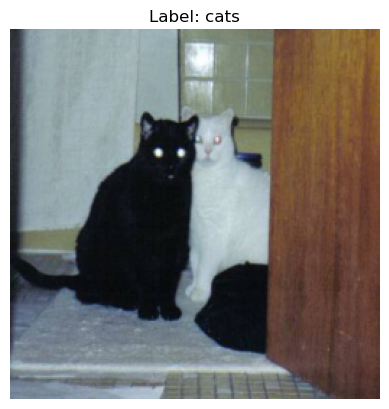

In [558]:
for images, labels in train_dataloader:
    print("Batch Shape:", images.shape, labels.shape)  # Expected: (32, 3, 256, 256)
    img = images[0] 
    img = img.permute(1, 2, 0)
    plt.imshow(img)
    plt.title(f"Label: {train_dataset.classes[labels[0]]}")
    plt.axis("off")
    plt.show()
    
    break 


In [ ]:
class DogCatClassfier(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, stride=1),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(64*32*32, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid(),

        )

    def forward(self, x):
        return self.layer(x)

In [560]:
# torch.manual_seed(2)
model = DogCatClassfier()

In [561]:
dummmy_img = torch.randn(size=(1,3,256,256))

In [562]:
from torchinfo import summary

summary(model, input_size=(16,3,256,256))

Layer (type:depth-idx)                   Output Shape              Param #
DogCatClassfier                          [16, 1]                   --
├─Sequential: 1-1                        [16, 1]                   --
│    └─Conv2d: 2-1                       [16, 16, 256, 256]        448
│    └─MaxPool2d: 2-2                    [16, 16, 128, 128]        --
│    └─Conv2d: 2-3                       [16, 32, 128, 128]        4,640
│    └─MaxPool2d: 2-4                    [16, 32, 64, 64]          --
│    └─Conv2d: 2-5                       [16, 64, 64, 64]          18,496
│    └─MaxPool2d: 2-6                    [16, 64, 32, 32]          --
│    └─Flatten: 2-7                      [16, 65536]               --
│    └─Linear: 2-8                       [16, 256]                 16,777,472
│    └─ReLU: 2-9                         [16, 256]                 --
│    └─Linear: 2-10                      [16, 128]                 32,896
│    └─ReLU: 2-11                        [16, 128]               

In [563]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [564]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, torch.round(y_pred).view(-1)).sum().item()
    return (correct/len(y_true))* 100

In [565]:
from tqdm.auto import tqdm

epochs = 2
for epoch in tqdm(range(epochs)):
    model.train()
    train_loss = 0
    train_accuracy = 0

    test_accuracy = 0

    for images, labels in tqdm(train_dataloader, leave=False):
        optimizer.zero_grad()
        y_pred = model(images)
        labels = labels.float()  # Convert from LongTensor to FloatTensor
        loss = loss_fn(y_pred.view(-1), labels)
        train_loss += loss
        train_accuracy += accuracy_fn(labels, y_pred)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.inference_mode():
        for images, labels in tqdm(test_dataloader, leave=False):
            y_pred = model(images)
            labels = labels.float()  # Convert from LongTensor to FloatTensor
            test_accuracy += accuracy_fn(labels, y_pred)

    train_loss /= len(train_dataloader)
    train_accuracy /= len(train_dataloader)

    test_accuracy /= len(train_dataloader)


    print(f"epochs : {epoch+1}/{epochs}, Train Loss : {train_loss:.4f}, Train_acc : {train_accuracy:.4f}, Test Acc : {test_accuracy:.4f}")

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epochs : 1/2, Train Loss : 49.6461, Train_acc : 50.0199, Test Acc : 25.1592


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
from pathlib import Path

# Create model dictory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save
MODEL_NAME = "dog_cat_calssifier.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models\dog_cat_calssifier.pth


In [ ]:
# ways to reduce overfitting

#Add more Data
# Data augmentation
# l1/l2 regularization
# Dropuout
# batch norm
# reduce complexity

### Adding Batch Normalization and Dropout Layer

In [ ]:
# Adding Batch normaliztion and dropout layer
import torch
import torch.nn as nn

class DogCatClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(3, 16, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(16),  # Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # Pooling

            # Conv Block 2
            nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # Conv Block 3
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Flatten(),  # Flatten for fully connected layer

            # Fully Connected Layers
            nn.Linear(64 * 32 * 32, 256),  # Adjusted input size
            nn.BatchNorm1d(256),  # BatchNorm for FC layer
            nn.ReLU(),

            nn.Linear(256, 1),
            nn.Sigmoid(),  # Sigmoid for binary classification
        )

    def forward(self, x):
        return self.layer(x)

# Example: Model summary
model1 = DogCatClassifier()


In [ ]:
from torchinfo import summary

summary(model1, input_size=(16,3,256,256))

In [ ]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.01)

In [ ]:
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Initialize lists to store loss & accuracy
train_losses = []
train_accuracies = []
test_accuracies = []

epochs = 5  # Set desired epochs

for epoch in tqdm(range(epochs)):
    model1.train()
    train_loss = 0
    train_accuracy = 0
    test_accuracy = 0

    for images, labels in tqdm(train_dataloader, leave=False):
        optimizer.zero_grad()
        y_pred = model1(images)
        labels = labels.float()  # Convert from LongTensor to FloatTensor
        loss = loss_fn(y_pred.view(-1), labels)
        train_loss += loss.item()  # Use .item() to avoid memory issues
        train_accuracy += accuracy_fn(labels, y_pred)
        loss.backward()
        optimizer.step()

    model1.eval()
    with torch.inference_mode():
        for images, labels in tqdm(test_dataloader, leave=False):
            y_pred = model1(images)
            labels = labels.float()
            test_accuracy += accuracy_fn(labels, y_pred)

    train_loss /= len(train_dataloader)
    train_accuracy /= len(train_dataloader)
    test_accuracy /= len(test_dataloader)  # Fixed denominator

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%")




In [ ]:
from pathlib import Path

# Create model dictory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save
MODEL_NAME = "dog_cat_calssifier_batch.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model1.state_dict(),
           f=MODEL_SAVE_PATH)

In [ ]:
# PLot graph between test accuracy and train accuracy
# Plot Train vs Test Accuracy
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), train_accuracies, label="Train Accuracy", marker='o')
plt.plot(range(1, epochs + 1), test_accuracies, label="Test Accuracy", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Train vs Test Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# using Model trained on colab

In [574]:
state_dict = torch.load("./models/dog_cat_calssifier_colab.pth", map_location=torch.device("cpu"))
print(state_dict.keys())  # See layer names


odict_keys(['layer.0.weight', 'layer.0.bias', 'layer.1.weight', 'layer.1.bias', 'layer.1.running_mean', 'layer.1.running_var', 'layer.1.num_batches_tracked', 'layer.4.weight', 'layer.4.bias', 'layer.5.weight', 'layer.5.bias', 'layer.5.running_mean', 'layer.5.running_var', 'layer.5.num_batches_tracked', 'layer.8.weight', 'layer.8.bias', 'layer.9.weight', 'layer.9.bias', 'layer.9.running_mean', 'layer.9.running_var', 'layer.9.num_batches_tracked', 'layer.13.weight', 'layer.13.bias', 'layer.16.weight', 'layer.16.bias'])


C:\Users\sande\AppData\Local\Temp\ipykernel_3744\2050886354.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("./models/dog_cat_calssifier_colab.pt

In [568]:
import torch

# Load the trained model
model1 = torch.load("./models/dog_cat_calssifier_colab.pth", map_location=torch.device("cpu"))

# Perform predictions on the test dataset
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to("cpu"), labels.to("cpu").float()
        outputs = model1(images)
        predictions = torch.round(outputs).squeeze()
        
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

# Print Accuracy
accuracy = (correct / total) * 100
print(f"Test Accuracy: {accuracy:.2f}%")


C:\Users\sande\AppData\Local\Temp\ipykernel_3744\255973072.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1 = torch.load("./models/dog_cat_calssifier_colab.pth", m

TypeError: 'collections.OrderedDict' object is not callable